In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

import bacco
import baccoemu

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import utils

%load_ext autoreload
%autoreload 2

Importing pyfftw first


2024-05-22 15:37:32.833006: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-22 15:37:33.073905: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-22 15:37:33.076159: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-22 15:37:36.040939: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-05-22 15:37:40.369138: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gp

In [2]:
npart = 512
box_size = 1000.0
param_names = ['omega_m', 'omega_baryon', 'h', 'n_s', 'sigma_8']

In [119]:
# Quijote LH test data

idx_LH_str = '0663'
dir_mocks = '/cosmos_storage/home/mpelle/Yin_data/Quijote'

fn_pred = f'{dir_mocks}/LH{idx_LH_str}/pred_pos_{idx_LH_str}.npy'
pred_disp = np.load(fn_pred)

fn_sim = f'{dir_mocks}/LH{idx_LH_str}/dis_{idx_LH_str}.npy'
sim_disp = np.load(fn_sim)

fn_lin = f'{dir_mocks}/LH{idx_LH_str}/lin_den_{idx_LH_str}.npy'
dens_lin = np.load(fn_lin)[0]

In [4]:
# copied from DataCreationPipeline.py

## Create regular grid and displace particles
print("Generating grid")
grid = bacco.visualization.uniform_grid(npix=npart, L=box_size, ndim=3, bounds=False)

print("Adding predicted displacements")
pred_pos = bacco.scaler.add_displacement(None,
                                    pred_disp,
                                    box=box_size,
                                    pos=grid.reshape(-1,3),
                                    vel=None,
                                    vel_factor=0,
                                    verbose=True)[0]

Generating grid


2024-05-22 15:37:57,123 bacco.scaler : Adding displacement field with a vel-factor=0.000000


Adding predicted displacements
bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


In [5]:
sim = None
sdm = False
ngrid1 = npart

In [6]:
# copied from DataCreationPipeline.py
   
## Start bias model class

#k_nyq = np.pi * npart / box_size
damping_scale = 0.7 #k_nyq
interlacing = False

print("Setting up bias model")
bmodel = bacco.BiasModel(sim=sim, linear_delta=dens_lin, ngrid=npart, ngrid1=None, 
                            sdm=sdm, mode="dm",
                            BoxSize=box_size,
                            npart_for_fake_sim=npart, damping_scale=damping_scale, 
                            bias_model='expansion', deposit_method="cic", 
                            use_displacement_of_nn=False, interlacing=interlacing, 
                            )

2024-05-22 15:38:00,006 bacco.BiasModel : Initialising Bias Model class ...


Setting up bias model


In [7]:
## Compute lagrangian fields
print("Computing lagrangian fields")
bias_fields = bmodel.bias_terms_lag()

2024-05-22 15:38:03,581 bacco.BiasModel : Computing delta_to_tidal_field with 48 threads...
2024-05-22 15:38:03,583 bacco.BiasModel : fttw plan
2024-05-22 15:38:03,583 bacco.BiasModel : Computing linear field ...
2024-05-22 15:38:03,586 bacco.BiasModel : Memory used: 8.513613824 Gigabytes
2024-05-22 15:38:03,603 bacco.BiasModel : fttw freqs
2024-05-22 15:38:03,604 bacco.BiasModel : tidk freqs


Computing lagrangian fields


2024-05-22 15:38:10,696 bacco.BiasModel : ifft
2024-05-22 15:38:45,458 bacco.BiasModel : Computing laplacian ...
2024-05-22 15:38:45,460 bacco.BiasModel : Memory used: 13.366984704 Gigabytes
2024-05-22 15:38:46,863 bacco.BiasModel : Computing bias terms in lagrangian coords ...
2024-05-22 15:38:46,865 bacco.BiasModel : Memory used: 13.900443648 Gigabytes
2024-05-22 15:38:47,105 bacco.BiasModel : Computing delta squared ...
2024-05-22 15:38:47,107 bacco.BiasModel : Memory used: 14.437056512 Gigabytes
2024-05-22 15:38:48,151 bacco.BiasModel : Computing tidal component G2 with the given tidal field
2024-05-22 15:38:48,152 bacco.BiasModel : Memory used: 14.974201856 Gigabytes


In [8]:
## Compute eulerian fields
print("Computing eulerian fields")
bias_terms_eul_pred=[]
for ii in range(0,len(bias_fields)):
    bias_terms_pred = bacco.statistics.compute_mesh(ngrid=npart, box=box_size, pos=pred_pos, 
                                mass = (bias_fields[ii]).flatten(), deposit_method='cic', 
                                interlacing=interlacing)
    bias_terms_eul_pred.append(bias_terms_pred)
bias_terms_eul_pred = np.array(bias_terms_eul_pred)

Computing eulerian fields


2024-05-22 15:39:03,225 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-05-22 15:39:03,226 bacco.statistics : starting deposit 1
2024-05-22 15:39:04,421 bacco.statistics :  mesh done in 1.2 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-05-22 15:39:04,891 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-05-22 15:39:04,892 bacco.statistics : starting deposit 1
2024-05-22 15:39:05,757 bacco.statistics :  mesh done in 0.866 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-05-22 15:39:06,216 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-05-22 15:39:06,217 bacco.statistics : starting deposit 1
2024-05-22 15:39:07,107 bacco.statistics :  mesh done in 0.891 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-05-22 15:39:07,575 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-05-22 15:39:07,577 bacco.statistics : starting deposit 1
2024-05-22 15:39:08,474 bacco.statistics :  mesh done in 0.899 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-05-22 15:39:08,933 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-05-22 15:39:08,934 bacco.statistics : starting deposit 1
2024-05-22 15:39:09,884 bacco.statistics :  mesh done in 0.951 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


Now with simulated (true):

In [9]:
# copied from DataCreationPipeline.py

## Create regular grid and displace particles
print("Generating grid")
grid = bacco.visualization.uniform_grid(npix=npart, L=box_size, ndim=3, bounds=False)

print("Adding predicted displacements")
sim_pos = bacco.scaler.add_displacement(None,
                                    sim_disp,
                                    box=box_size,
                                    pos=grid.reshape(-1,3),
                                    vel=None,
                                    vel_factor=0,
                                    verbose=True)[0]

Generating grid


2024-05-22 15:39:21,633 bacco.scaler : Adding displacement field with a vel-factor=0.000000


Adding predicted displacements
bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


In [10]:
print("Setting up bias model")
bmodel_sim = bacco.BiasModel(sim=sim, linear_delta=dens_lin, ngrid=npart, ngrid1=None, 
                            sdm=sdm, mode="dm",
                            BoxSize=box_size,
                            npart_for_fake_sim=npart, damping_scale=damping_scale, 
                            bias_model='expansion', deposit_method="cic", 
                            use_displacement_of_nn=False, interlacing=interlacing, 
                            )

2024-05-22 15:39:23,523 bacco.BiasModel : Initialising Bias Model class ...


Setting up bias model


In [11]:

## Compute lagrangian fields
print("Computing lagrangian fields")
bias_fields_sim = bmodel_sim.bias_terms_lag()

2024-05-22 15:39:27,702 bacco.BiasModel : Computing delta_to_tidal_field with 48 threads...
2024-05-22 15:39:27,703 bacco.BiasModel : fttw plan
2024-05-22 15:39:27,703 bacco.BiasModel : Computing linear field ...
2024-05-22 15:39:27,704 bacco.BiasModel : Memory used: 17.130627072 Gigabytes
2024-05-22 15:39:27,713 bacco.BiasModel : fttw freqs
2024-05-22 15:39:27,714 bacco.BiasModel : tidk freqs


Computing lagrangian fields


2024-05-22 15:39:36,158 bacco.BiasModel : ifft
2024-05-22 15:40:17,461 bacco.BiasModel : Computing laplacian ...
2024-05-22 15:40:17,464 bacco.BiasModel : Memory used: 21.972553728 Gigabytes
2024-05-22 15:40:18,820 bacco.BiasModel : Computing bias terms in lagrangian coords ...
2024-05-22 15:40:18,821 bacco.BiasModel : Memory used: 22.50651648 Gigabytes
2024-05-22 15:40:19,072 bacco.BiasModel : Computing delta squared ...
2024-05-22 15:40:19,073 bacco.BiasModel : Memory used: 23.043301376 Gigabytes
2024-05-22 15:40:20,319 bacco.BiasModel : Computing tidal component G2 with the given tidal field
2024-05-22 15:40:20,320 bacco.BiasModel : Memory used: 23.580266496 Gigabytes


In [12]:
## Compute eulerian fields
print("Computing eulerian fields")
bias_terms_eul_sim=[]
for ii in range(0,len(bias_fields)):
    bias_terms_sim = bacco.statistics.compute_mesh(ngrid=npart, box=box_size, pos=sim_pos, 
                                mass = (bias_fields[ii]).flatten(), deposit_method='cic', 
                                interlacing=interlacing)
    bias_terms_eul_sim.append(bias_terms_sim)
bias_terms_eul_sim = np.array(bias_terms_eul_sim)

Computing eulerian fields


2024-05-22 15:40:34,627 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-05-22 15:40:34,628 bacco.statistics : starting deposit 1


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0


2024-05-22 15:40:35,777 bacco.statistics :  mesh done in 1.15 s


bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-05-22 15:40:36,750 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-05-22 15:40:36,751 bacco.statistics : starting deposit 1
2024-05-22 15:40:37,695 bacco.statistics :  mesh done in 0.945 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-05-22 15:40:38,642 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-05-22 15:40:38,642 bacco.statistics : starting deposit 1
2024-05-22 15:40:39,484 bacco.statistics :  mesh done in 0.842 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-05-22 15:40:40,486 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-05-22 15:40:40,487 bacco.statistics : starting deposit 1
2024-05-22 15:40:41,364 bacco.statistics :  mesh done in 0.878 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-05-22 15:40:42,288 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-05-22 15:40:42,289 bacco.statistics : starting deposit 1


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-05-22 15:40:43,165 bacco.statistics :  mesh done in 0.877 s


### Compute p(k)

In [88]:
def get_tracer_field(bias_fields_eul, bias_vector):

    def _sum_bias_fields(fields, bias_vector):
        bias_vector_extended = np.concatenate(([1.0], bias_vector))
        return np.sum([fields[ii]*bias_vector_extended[ii] for ii in range(len(bias_vector))], axis=0)
    
    tracer_field_eul = _sum_bias_fields(bias_fields_eul, bias_vector)
    print(tracer_field_eul.shape)
    # normalize by 512 because that's the original ngrid size
    tracer_field_eul_norm512 = tracer_field_eul/512**3
    return tracer_field_eul_norm512

In [89]:
def compute_pk(tracer_field, cosmo, n_grid, n_threads=8, box_size=1000.0):

    # param_vals = np.loadtxt(fn_params)
    # param_dict = dict(zip(param_names, param_vals))
    # cosmo = get_cosmo(param_dict)

    k_min = 0.01
    k_max = 1.0
    n_bins = 30
    log_binning = True

    args_power = {'ngrid':n_grid,
                'box':box_size,
                'cosmology':cosmo,
                'interlacing':False,
                'kmin':k_min,
                'kmax':k_max,
                'nbins':n_bins,
                'correct_grid':True,
                'log_binning':log_binning,
                'deposit_method':'cic',
                'compute_correlation':False,
                'zspace':False,
                'compute_power2d':False}
    
    bacco.configuration.update({'number_of_threads': n_threads})

    # NOTE assumes tracer field is already normalized!
    pk = bacco.statistics.compute_crossspectrum_twogrids(
                        grid1=tracer_field,
                        grid2=tracer_field,
                        normalise_grid1=False,
                        normalise_grid2=False,
                        deconvolve_grid1=False,
                        deconvolve_grid2=False,
                        **args_power)
    
    return pk

In [120]:
def get_cosmo(param_dict):
    a_scale = 1
    # omega_m = omega_cold + omega_neutrinos 
    # (omega_m = omega_cold if no neutrinos) 
    # Om_cdm = Om_cold - Om_baryon
    if 'omega_m' in param_dict:
        omega_cdm = param_dict['omega_m']-param_dict['omega_baryon']
    elif 'omega_cold' in param_dict:
        omega_cdm = param_dict['omega_cold']-param_dict['omega_baryon']
    else:
        raise ValueError("param_dict must include omega_m or omega_cold!")

    cosmopars = dict(
            omega_cdm=omega_cdm,
            omega_baryon=param_dict['omega_baryon'],
            hubble=param_dict['h'],
            ns=param_dict['n_s'],
            sigma8=param_dict['sigma_8'],
            tau=0.0561,
            A_s=None,
            neutrino_mass=0.,
            w0=-1,
            wa=0,
        )

    cosmo = bacco.Cosmology(**cosmopars)
    cosmo.set_expfactor(a_scale)
    return cosmo

In [124]:
fn_params = f'{dir_mocks}/LH{idx_LH_str}/param_{idx_LH_str}.txt'
param_vals = np.loadtxt(fn_params)
param_dict = dict(zip(param_names, param_vals))
cosmo_Quijote = get_cosmo(param_dict)

2024-05-22 17:55:49,578 bacco.cosmo :    initialization took 0.000 secs


In [125]:
bias_vector = [0., 0., 0., 0.]

In [126]:
tracer_field_pred = get_tracer_field(bias_terms_eul_pred, bias_vector)


(1, 512, 512, 512)


In [127]:
n_grid = 512
pk_obj_pred = compute_pk(tracer_field_pred, cosmo_Quijote, n_grid)

2024-05-22 17:56:25,255 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2024-05-22 17:56:25,500 bacco.cosmo :    computed CAMB power spectrum at z=0.00 in 0.243 secs
2024-05-22 17:56:25,505 bacco.cosmo :    created Pk(z=0) tab from k 7.127584103727715e-05 to 100000.0 h/Mpc
2024-05-22 17:56:25,509 bacco.cosmo :    computed halofit at z=0.00 for 'Default' in 0.002 secs


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.530131 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.447096 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000157 secs
bacco.power : Deallocating arrays


2024-05-22 17:56:31,802 bacco.statistics :  ...done in 6.55 s


In [128]:
kk = pk_obj_pred['k']

In [129]:
tracer_field_sim = get_tracer_field(bias_terms_eul_sim, bias_vector)


(1, 512, 512, 512)


In [130]:
pk_obj_sim = compute_pk(tracer_field_sim, cosmo_Quijote, n_grid)

2024-05-22 17:56:40,545 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.516978 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.455649 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000171 secs
bacco.power : Deallocating arrays


2024-05-22 17:56:47,225 bacco.statistics :  ...done in 6.68 s


### Emulators

In [85]:
emu_lbias, emu_bounds, emu_param_names = utils.load_emu()
emu_bounds_dict = dict(zip(emu_param_names, emu_bounds))


Loading l-bias lpt emulator...


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 whe

L-bias lpt emulator loaded in memory.
Loading smeared bao emulator...
Smeared bao emulator loaded in memory.
Loading non-linear l-bias emulator...


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.1.1

Nonlinear l-bias emulator loaded in memory.
HIIII


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [24]:
emu_mpk_ext, emu_bounds_mpk_ext, emu_param_names_mpk_ext = utils.load_emu(emu_name='mpk_extended')
emu_bounds_dict_mpk_ext = dict(zip(emu_param_names_mpk_ext, emu_bounds_mpk_ext))

Loading sigma8 emulator...
HIIII
Sigma8 emulator loaded in memory.
Loading linear emulator...


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using v

Linear emulator loaded in memory.
Loading no-wiggles emulator...


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


No-wiggles emulator loaded in memory.
Loading non-linear emulator...
Nonlinear emulator loaded in memory.
Loading Baryonic Emulator...
Baryonic Emulator loaded in memory.


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.23.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [25]:
param_names_2_emu_param_names = {'sigma_8': 'sigma8_cold',
                                 'omega_cold': 'omega_cold',
                                 'omega_baryon': 'omega_baryon',
                                 'h': 'hubble',
                                 'n_s': 'ns'}
emu_param_names = [param_names_2_emu_param_names[param_name] for param_name in param_names if param_name in param_names_2_emu_param_names]

cosmo_params = {
    'neutrino_mass' :  0.0,
    'w0'            : -1.0,
    'wa'            :  0.0,
    'expfactor'     :  1
}

In [26]:
# idxs_LH = np.array([10,29,37,40,70,85,127,158,165,184,208,220,240,254,267,274,293,305,336,374,375,388,433,444,
#                       464,502,534,542,574,598,605,628,652,663,676,700,702,721,737,762,809,822,825,837,853,864,882,
#                       899,901,911,939,948,950,951,964,976,977,1016,1022,1041,1050,1060,1082,1091,1103,1114,1147,
#                       1157,1173,1175,1219,1222,1299,1309,1314,1317,1331,1365,1372,1378,1391,1397,1418,1444,1459,
#                       1510,1512,1513,1515,1517,1533,1553,1567,1568,1599,1622,1642,1657,1659,1667])
# for idx_LH in idxs_LH:
#     idx_LH_str = f'{idx_LH:04}'
#     fn_params = f'{dir_mocks}/LH{idx_LH_str}/param_{idx_LH_str}.txt'
#     param_vals = np.loadtxt(fn_params)
#     param_dict = dict(zip(param_names, param_vals))

#     for param_name in param_names:
#         if param_name=='omega_m':
#             # no neutrinos, so omega_cold = omega_m
#             emu_param_name = 'omega_cold'
#         else:
#             emu_param_name = param_names_2_emu_param_names[param_name]
#         cosmo_params[emu_param_name] = param_dict[param_name]
    
#     try:       
#         _, pk_lbias, _ = emu_lbias.get_galaxy_real_pk(bias=bias_vector, k=kk, 
#                                                             **cosmo_params)
#         print("got it!", idx_LH_str)
#         break
#     except AssertionError:
#         pass

In [131]:
#cosmo_params_emu = utils.setup_cosmo_emu(cosmo='quijote')
fn_params = f'{dir_mocks}/LH{idx_LH_str}/param_{idx_LH_str}.txt'
param_vals = np.loadtxt(fn_params)
param_dict = dict(zip(param_names, param_vals))

for param_name in param_names:
    if param_name=='omega_m':
        # no neutrinos, so omega_cold = omega_m
        emu_param_name = 'omega_cold'
    else:
        emu_param_name = param_names_2_emu_param_names[param_name]
    cosmo_params[emu_param_name] = param_dict[param_name]

# max of lbias emu
kk_lbias = kk[kk<0.75]        
_, pk_emu_lbias, _ = emu_lbias.get_galaxy_real_pk(bias=bias_vector, k=kk_lbias, 
                                                    **cosmo_params)
_, pk_emu, = emu_mpk_ext.get_nonlinear_pk(k=kk, cold=True,
                                                        **cosmo_params)

### Plot

In [133]:
# linear
k_input = cosmo_Quijote._tabPowerSpectrum_z0['x']
pk_input = cosmo_Quijote._tabPowerSpectrum_z0['y']

k, pk_lin_cold = emu_mpk_ext.get_linear_pk(k=kk, cold=True, **cosmo_params)


/tmp/ipykernel_4117/3427520565.py:33: RuntimeWarning: divide by zero encountered in divide
  ax1.plot(kk, (pk_emu-pk_m2m)/gaussian_error_pk_pred, ls='-', alpha=alpha, color=color_pk_pred)
/tmp/ipykernel_4117/3427520565.py:34: RuntimeWarning: divide by zero encountered in divide
  ax1.plot(kk, (pk_emu-pk_sim)/gaussian_error_pk_sim, ls='--', alpha=alpha, color=color_pk_sim)
/tmp/ipykernel_4117/3427520565.py:38: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(kk, pk_emu/pk_m2m, ls='-', alpha=alpha, color=color_pk_pred)
/tmp/ipykernel_4117/3427520565.py:39: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(kk, pk_emu/pk_sim, ls='--', alpha=alpha, color=color_pk_sim)


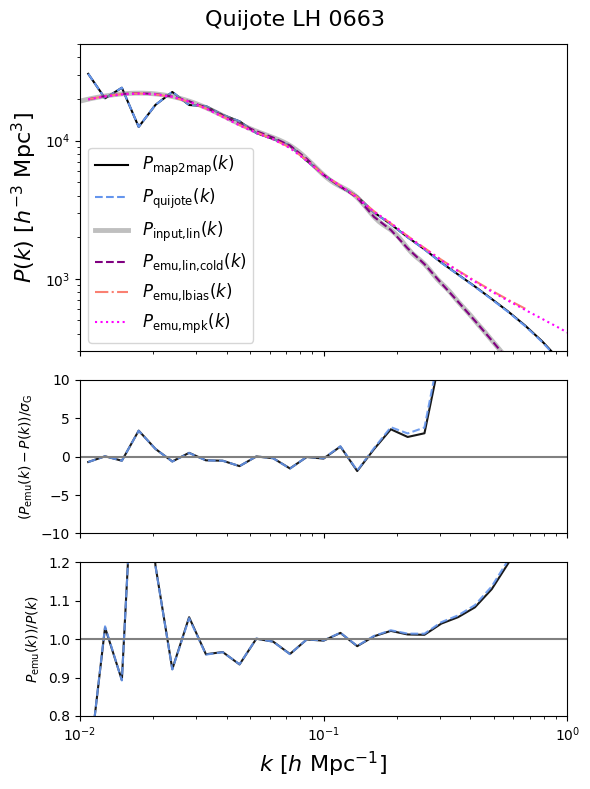

In [135]:
nrows, ncols = 3, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,8), sharex=True, height_ratios=[2,1,1])
plt.subplots_adjust(hspace=0.01, wspace=0.01)
ax, ax1, ax2 = axarr

color_pk_pred, color_pk_cold, color_pk_tot = 'black', 'purple', 'navy', 
color_pk_emu, color_pk_emu_lbias = 'magenta', 'salmon'
color_inlin = 'grey'
color_pk_sim = 'cornflowerblue'

n_plot = 1

# the predictions are from map2map, computed by Marcos
pk_m2m = pk_obj_pred['pk']
pk_sim = pk_obj_sim['pk']
gaussian_error_pk_pred = pk_obj_pred['pk_gaussian_error']
gaussian_error_pk_sim = pk_obj_sim['pk_gaussian_error']

plt.suptitle(f'Quijote LH {idx_LH_str}', fontsize=16)

ax.loglog(kk, pk_m2m, label=r'$P_\text{map2map}(k)$', color=color_pk_pred)
ax.loglog(kk, pk_sim, ls='--', label=r'$P_\text{quijote}(k)$', color=color_pk_sim)
ax.loglog(k_input, pk_input, label=r'$P_\text{input,lin}(k)$', color=color_inlin, lw=3.5, alpha=0.5)
ax.loglog(k, pk_lin_cold, label=r'$P_\text{emu,lin,cold}(k)$', color=color_pk_cold, ls='--')
# ax.loglog(k, pk_lin_total, label=r'$P_\text{emu,lin,tot}(k)$', ls='--', color=color_pk_tot)
ax.loglog(kk_lbias, pk_emu_lbias, label=r'$P_\text{emu,lbias}(k)$', ls='-.', color=color_pk_emu_lbias)
ax.loglog(kk, pk_emu, label=r'$P_\text{emu,mpk}(k)$', ls=':', color=color_pk_emu)

#ax.loglog(kk, Pk_lin[idx_LH], label=r'$P_\text{lin}(k)$')
#ax.loglog(kk, Pk_nl[idx_LH], label=r'$P_\text{nl}(k)$')

alpha = 0.9
ax1.plot(kk, (pk_emu-pk_m2m)/gaussian_error_pk_pred, ls='-', alpha=alpha, color=color_pk_pred)
ax1.plot(kk, (pk_emu-pk_sim)/gaussian_error_pk_sim, ls='--', alpha=alpha, color=color_pk_sim)
# ax1.plot(k, (pk_lbias_public-pk_m2m)/denom, ls='-.', alpha=0.5, color=color_pk_lbias_public)

# actually compare to emu !
ax2.plot(kk, pk_emu/pk_m2m, ls='-', alpha=alpha, color=color_pk_pred)
ax2.plot(kk, pk_emu/pk_sim, ls='--', alpha=alpha, color=color_pk_sim)


# ax2.plot(k, (pk_lbias-pk_m2m)/pk_m2m, ls=':', alpha=0.5, color=color_pk_lbias)
# ax2.plot(k, (pk_obj_sim['pk']-pk_m2m)/pk_m2m, ls='-', alpha=0.5, color=color_pk_sim)

ax1.axhline(0.0, color='grey')
#ax2.axhline(0.0, color='grey')
ax2.axhline(1.0, color='grey')

ax2.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)
ax1.set_ylabel(r'$(P_\text{emu}(k)-P(k))/\sigma_\text{G}$')
#ax2.set_ylabel(r'$(P(k)-P_\text{map2map}(k))$'+'\n'+r'$/P_\text{map2map}(k)$')
ax2.set_ylabel(r'$P_\text{emu}(k))/P(k)$')
ax.set_xlim(1e-2, 1)
ax.set_ylim(3e2, 5e4)

ax1.set_ylim(-10, 10)
#ax2.set_ylim(-0.1, 0.1)
ax2.set_ylim(0.8, 1.2)
#ax2.set_ylim(0.5, 1.5)


ax.legend(fontsize=12)

mpl.pyplot.tight_layout()
mpl.pyplot.show()

### Check single quijote

In [ ]:
# idx_LH_str = '0010'
# dir_mocks = '/cosmos_storage/home/mpelle/Yin_data/Quijote'
# dir_fields = '../data/quijote_LH'
# tag_pk = '_b0000'
# fn_fields_sim = f'{dir_fields}/LH{idx_LH_str}/Eulerian_fields_sim_{idx_LH_str}.npy'

# dir_pks_sim = f'../data/pks_quijote_LH/pks_sim{tag_pk}'
# dir_pks_pred = f'../data/pks_quijote_LH/pks_pred{tag_pk}'

# fn_bias_vector = f'{dir_pks_sim}/bias_params.txt' #same for sim and pred
# bias_params = np.loadtxt(fn_bias_vector)

In [ ]:
#bias_terms_eul_sim = np.load(fn_fields_sim)

In [ ]:
#tracer_field_sim = get_tracer_field(bias_terms_eul_sim, bias_vector)

(1, 512, 512, 512)


In [ ]:
# n_grid = 512
# pk_obj_sim = compute_pk(tracer_field_sim, cosmo_Quijote, n_grid)
# print(pk_obj_sim['pk'])

2024-04-09 15:42:32,056 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 2.23517e-08 (grid1) 2.23517e-08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.543300 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.287129 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000165 secs
bacco.power : Deallocating arrays


2024-04-09 15:42:37,913 bacco.statistics :  ...done in 5.86 s


[4.95530787e-07 4.94205677e-07 4.97421635e-07 4.99759756e-07
 5.00982765e-07 4.99848104e-07 5.00360074e-07 5.03177745e-07
 5.00232067e-07 4.95367786e-07 4.99660536e-07 4.98800951e-07
 4.97393066e-07 4.96078171e-07 4.93706549e-07 4.91435119e-07
 4.88514719e-07 4.85912618e-07 4.77589408e-07 4.71135622e-07
 4.66582050e-07 4.54257678e-07 4.38096149e-07 4.26537975e-07
 4.02154889e-07 3.82314895e-07 3.51740431e-07 3.20525370e-07
 2.84319655e-07 0.00000000e+00]


In [ ]:
#pk_obj_sim['pk']

array([4.95530787e-07, 4.94205677e-07, 4.97421635e-07, 4.99759756e-07,
       5.00982765e-07, 4.99848104e-07, 5.00360074e-07, 5.03177745e-07,
       5.00232067e-07, 4.95367786e-07, 4.99660536e-07, 4.98800951e-07,
       4.97393066e-07, 4.96078171e-07, 4.93706549e-07, 4.91435119e-07,
       4.88514719e-07, 4.85912618e-07, 4.77589408e-07, 4.71135622e-07,
       4.66582050e-07, 4.54257678e-07, 4.38096149e-07, 4.26537975e-07,
       4.02154889e-07, 3.82314895e-07, 3.51740431e-07, 3.20525370e-07,
       2.84319655e-07, 0.00000000e+00])

### Compare many LHs - quijote vs map2map

In [1]:
ngrid = 512
box_size = 1000.

idxs_LH = np.array([10,29,37,40,70,85,127,158,165,184,208,220,240,254,267,274,293,305,336,374,375,388,433,444,
                      464,502,534,542,574,598,605,628,652,663,676,700,702,721,737,762,809,822,825,837,853,864,882,
                      899,901,911,939,948,950,951,964,976,977,1016,1022,1041,1050,1060,1082,1091,1103,1114,1147,
                      1157,1173,1175,1219,1222,1299,1309,1314,1317,1331,1365,1372,1378,1391,1397,1418,1444,1459,
                      1510,1512,1513,1515,1517,1533,1553,1567,1568,1599,1622,1642,1657,1659,1667])

NameError: name 'np' is not defined

In [ ]:
tag_pk = '_b0000'
dir_pks_sim = f'../data/pks_quijote_LH/pks_sim{tag_pk}'
dir_pks_pred = f'../data/pks_quijote_LH/pks_pred{tag_pk}'
dir_mocks = '/cosmos_storage/home/mpelle/Yin_data/Quijote' #need for params

fn_bias_vector = f'{dir_pks_sim}/bias_params.txt' #same for sim and pred
bias_params = np.loadtxt(fn_bias_vector)
param_names = ['omega_m', 'omega_baryon', 'h', 'n_s', 'sigma_8']

In [ ]:
idxs_LH_inbounds = []
theta = []

for i, idx_LH in enumerate(idxs_LH):    
#for i, idx_LH in enumerate(idxs_LH[:48]):    

    idx_LH_str = f'{idx_LH:04}' 

    fn_params = f'{dir_mocks}/LH{idx_LH_str}/param_{idx_LH_str}.txt'
    param_vals = np.loadtxt(fn_params)
    param_dict = dict(zip(param_names, param_vals))
    out_of_bounds = False # til we check, below

    if i % 100 == 0:
        print(i)
    for param_name in param_names:
        if param_name=='omega_m':
            # no neutrinos, so omega_cold = omega_m
            emu_param_name = 'omega_cold'
        else:
            emu_param_name = param_names_2_emu_param_names[param_name]
        cosmo_params[emu_param_name] = param_dict[param_name]
        
        # print(param_name, param_dict[param_name])
        # print(emu_param_name, emu_bounds_dict[emu_param_name])
        
        # check in bounds
        if (param_dict[param_name] < emu_bounds_dict_mpk_ext[emu_param_name][0]) or \
           (param_dict[param_name] > emu_bounds_dict_mpk_ext[emu_param_name][1]):
            #print(f"params for {idx_LH} OOB!")    
            out_of_bounds = True
            break
    
    if out_of_bounds:
        continue
    
    idxs_LH_inbounds.append(idx_LH)
    theta.append(param_vals)

theta = np.array(theta)

print(len(idxs_LH_inbounds))

0
59


In [ ]:
pks_sim = []
pks_pred = []
for idx_LH in idxs_LH_inbounds:
    idx_LH_str = f'{idx_LH:04}' 
    
    fn_pk_sim = f'{dir_pks_sim}/pk_{idx_LH_str}.npy'
    pks_sim.append( np.load(fn_pk_sim, allow_pickle=True).item() )
    
    fn_pk_pred = f'{dir_pks_pred}/pk_{idx_LH_str}.npy'
    pks_pred.append( np.load(fn_pk_pred, allow_pickle=True).item() )



In [ ]:
Pk_sim = np.array([pk['pk'] for pk in pks_sim])
Pk_pred = np.array([pk['pk'] for pk in pks_pred])
gaussian_error_pk_sim = np.array([pk['pk_gaussian_error'] for pk in pks_sim])
gaussian_error_pk_pred = np.array([pk['pk_gaussian_error'] for pk in pks_pred])
k = pks_sim[0]['k']

In [ ]:
Pk_emu = []
for i, idx_LH in enumerate(idxs_LH_inbounds):
    param_dict = dict(zip(param_names, theta[i]))
    for param_name in param_names:
        if param_name=='omega_m':
            # no neutrinos, so omega_cold = omega_m
            emu_param_name = 'omega_cold'
        else:
            emu_param_name = param_names_2_emu_param_names[param_name]
        cosmo_params[emu_param_name] = param_dict[param_name]
    
    #_, pk_model_unscaled, _ = emu_lbias.get_galaxy_real_pk(bias=bias_params, k=k, 
    #                                                       **cosmo_params)
    _, pk_model_unscaled, = emu_mpk_ext.get_nonlinear_pk(k=k, cold=True,
                                                           **cosmo_params)
    Pk_emu.append(pk_model_unscaled)
    
Pk_emu = np.array(Pk_emu)

In [ ]:
param_names_2_emu_param_names = {'sigma_8': 'sigma8_cold',
                                 'omega_cold': 'omega_cold',
                                 'omega_baryon': 'omega_baryon',
                                 'h': 'hubble',
                                 'n_s': 'ns'}
emu_param_names = [param_names_2_emu_param_names[param_name] for param_name in param_names if param_name in param_names_2_emu_param_names]

In [ ]:
cosmo_params = {
    'neutrino_mass' :  0.0,
    'w0'            : -1.0,
    'wa'            :  0.0,
    'expfactor'     :  1
}

In [ ]:
print(np.min(theta, axis=0))
print(np.max(theta, axis=0))
# checks out with order ['omega_m', 'omega_baryon', 'h', 'n_s', 'sigma_8']!

[0.1505  0.03335 0.5147  0.8309  0.6229 ]
[0.4679  0.06729 0.8877  1.0951  0.9793 ]


/tmp/ipykernel_4117/1800013040.py:42: RuntimeWarning: divide by zero encountered in divide
  axarr[1].plot(k, (pk_model_unscaled-Pk_sim[i])/gaussian_error_pk_sim[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
/tmp/ipykernel_4117/1800013040.py:43: RuntimeWarning: divide by zero encountered in divide
  axarr[2].plot(k, (pk_model_unscaled-Pk_pred[i])/gaussian_error_pk_pred[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
/tmp/ipykernel_4117/1800013040.py:44: RuntimeWarning: invalid value encountered in divide
  axarr[3].plot(k, (Pk_pred[i]-Pk_sim[i])/gaussian_error_pk_sim[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
/tmp/ipykernel_4117/1800013040.py:63: RuntimeWarning: divide by zero encountered in divide
  diff_Pksim_overG = diff_Pksim/gaussian_error_pk_sim
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/tmp/ipykernel_4117/1800013040.py:69: RuntimeWarning:

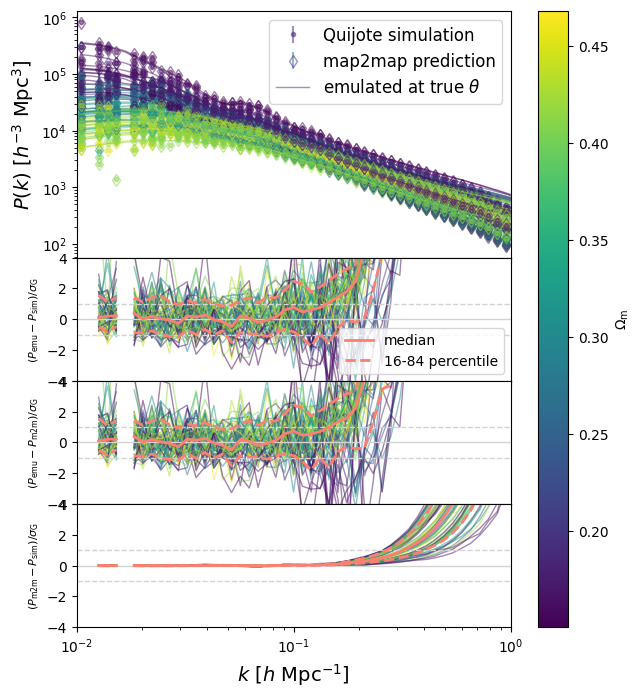

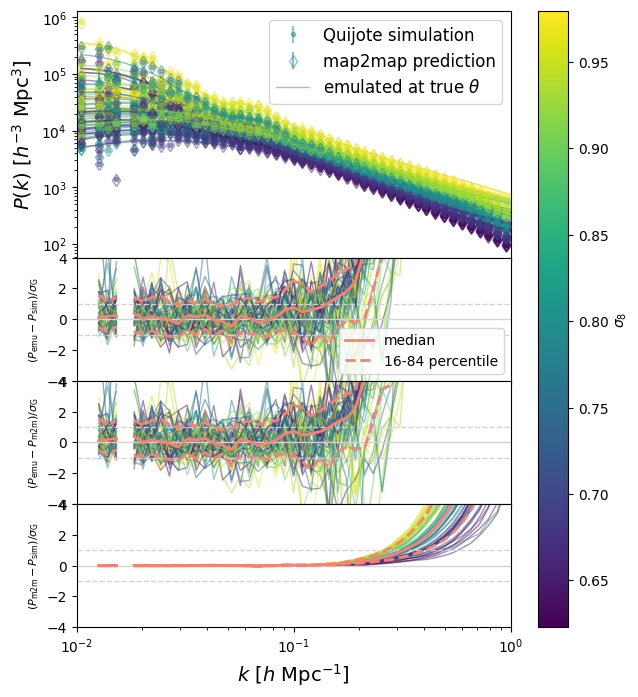

In [ ]:
param_names_compare = ['omega_m', 'sigma_8']

for param_name_compare in param_names_compare:
    idx_param = param_names.index(param_name_compare)
    param_vals = np.array([theta[i][idx_param] for i in range(theta.shape[0])])

    normalizer = mpl.colors.Normalize(vmin=np.min(param_vals), vmax=np.max(param_vals))
    sm = mpl.cm.ScalarMappable(norm=normalizer, cmap=mpl.cm.viridis)#.to_rgba(cvals)
    colors = sm.to_rgba(param_vals)
        

    nrows, ncols = 4, 1
    fig, axarr = plt.subplots(nrows, ncols, figsize=(7,8), sharex=True, height_ratios=[2,1,1,1])
    plt.subplots_adjust(hspace=0)
        
    lw = 1
    show_error_all = False
    first = True
    for i, idx_LH in enumerate(idxs_LH_inbounds):
    
        pk_model_unscaled = Pk_emu[i]
        
        label_true, label_emu, label_stdev = None, None, None
        if first:
            label_true = 'Quijote simulation'
            label_emu = r'emulated at true $\theta$'
            label_stdev = r'$0.2*\sigma_\text{stdev}(P_\text{train}(k))$'
            
        if first or show_error_all:
            axarr[0].errorbar(k, Pk_sim[i], yerr=gaussian_error_pk_sim[i], 
                            ls='None', marker='o', markersize=3, alpha=0.5, label=label_true, color=colors[i])
            axarr[0].errorbar(k, Pk_pred[i], yerr=gaussian_error_pk_pred[i], ls='None', marker='d', markersize=6, alpha=0.5, 
                            label='map2map prediction', 
                        markerfacecolor='None', markeredgecolor=colors[i])
        else:
            axarr[0].plot(k, Pk_sim[i], ls='None', marker='o', markersize=3, alpha=0.5, color=colors[i])
            axarr[0].plot(k, Pk_pred[i], ls='None', marker='d', markersize=6, alpha=0.5,
                        markerfacecolor='None', markeredgecolor=colors[i])
        
        axarr[0].plot(k, pk_model_unscaled, ls='-', alpha=0.5, label=label_emu, color=colors[i], lw=lw)

        axarr[1].plot(k, (pk_model_unscaled-Pk_sim[i])/gaussian_error_pk_sim[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
        axarr[2].plot(k, (pk_model_unscaled-Pk_pred[i])/gaussian_error_pk_pred[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
        axarr[3].plot(k, (Pk_pred[i]-Pk_sim[i])/gaussian_error_pk_sim[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
        #axarr[4].plot(k, (Pk_pred[i]/Pk_sim[i]), ls='-', alpha=0.5, color=colors[i], lw=lw)
            
        first = False
        
    axarr[1].axhline(0, color='lightgrey', lw=1)
    axarr[2].axhline(0, color='lightgrey', lw=1)
    axarr[3].axhline(0, color='lightgrey', lw=1)
    #axarr[4].axhline(1.0, color='lightgrey', lw=1)

    ls_1sig='--'
    axarr[1].axhline(-1, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[1].axhline(1, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[2].axhline(-1, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[2].axhline(1, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[3].axhline(-1, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[3].axhline(1, color='lightgrey', lw=1, ls=ls_1sig)

    diff_Pksim = Pk_emu - Pk_sim
    diff_Pksim_overG = diff_Pksim/gaussian_error_pk_sim
    diff_Pksim_overG_16 = np.percentile(diff_Pksim_overG, 16, axis=0)
    diff_Pksim_overG_84 = np.percentile(diff_Pksim_overG, 84, axis=0)
    diff_Pksim_overG_med = np.median(diff_Pksim_overG, axis=0)

    diff_Pkpred = Pk_emu - Pk_pred
    diff_Pkpred_overG = diff_Pkpred/gaussian_error_pk_pred
    diff_Pkpred_overG_16 = np.percentile(diff_Pkpred_overG, 16, axis=0)
    diff_Pkpred_overG_84 = np.percentile(diff_Pkpred_overG, 84, axis=0)
    diff_Pkpred_overG_med = np.median(diff_Pkpred_overG, axis=0)

    diff = Pk_pred - Pk_sim
    diff_overG = diff/gaussian_error_pk_sim
    diff_overG_16 = np.percentile(diff_overG, 16, axis=0)
    diff_overG_84 = np.percentile(diff_overG, 84, axis=0)
    diff_overG_med = np.median(diff_overG, axis=0)

    # ratio = Pk_pred/Pk_sim
    # ratio_16 = np.percentile(ratio, 16, axis=0)
    # ratio_84 = np.percentile(ratio, 84, axis=0)
    # ratio_med = np.median(ratio, axis=0)

    alpha_16_84 = 0.5
    axarr[1].plot(k, diff_Pksim_overG_med, color='salmon', lw=2, label='median')
    axarr[1].plot(k, diff_Pksim_overG_16, color='salmon', lw=2, ls='--', label='16-84 percentile')
    axarr[1].plot(k, diff_Pksim_overG_84, color='salmon', lw=2, ls='--')

    axarr[2].plot(k, diff_Pkpred_overG_med, color='salmon', lw=2)
    axarr[2].plot(k, diff_Pkpred_overG_16, color='salmon', lw=2, ls='--')
    axarr[2].plot(k, diff_Pkpred_overG_84, color='salmon', lw=2, ls='--')

    axarr[3].plot(k, diff_overG_med, color='salmon', lw=2)
    axarr[3].plot(k, diff_overG_16, color='salmon', lw=2, ls='--')
    axarr[3].plot(k, diff_overG_84, color='salmon', lw=2, ls='--')

    # axarr[4].plot(k, ratio_med, color='salmon', lw=2)
    # axarr[4].plot(k, ratio_16, color='salmon', lw=2, ls='--')
    # axarr[4].plot(k, ratio_84, color='salmon', lw=2, ls='--')

    # plot settings
    plt.xscale('log')
    axarr[0].set_yscale('log')
        
    plt.xlim(1e-2, 1)
    #axarr[0].set_ylim(1e3, 5e5)
    #axarr[0].set_ylim(1e2, 2e5)

    axarr[1].set_ylim(-4, 4)
    axarr[2].set_ylim(-4, 4)
    axarr[3].set_ylim(-4, 4)
    #axarr[4].set_ylim(0.99, 1.01)
        
    handles, labels = axarr[0].get_legend_handles_labels()

    if len(handles)>1:
        #order = [1,0,2]
        order = [1,2,0]
        #order = [1,0]
        axarr[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=12)
    # axarr[0].legend(fontsize=12)
    handles, labels = axarr[1].get_legend_handles_labels()
    axarr[1].legend(fontsize=10)

    plt.xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=14)
    axarr[0].set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=14)    
    fontsize_errs = 8
    axarr[1].set_ylabel(r'$(P_\text{emu}-P_\text{sim})/\sigma_\text{G}$', fontsize=fontsize_errs)
    axarr[2].set_ylabel(r'$(P_\text{emu}-P_\text{m2m})/\sigma_\text{G}$', fontsize=fontsize_errs)
    axarr[3].set_ylabel(r'$(P_\text{m2m}-P_\text{sim})/\sigma_\text{G}$', fontsize=fontsize_errs)
    #axarr[4].set_ylabel(r'$(P_\text{m2m}/P_\text{sim})$', fontsize=fontsize_errs)

    cbar = plt.colorbar(sm, ax=axarr.ravel().tolist())
    cbar.set_label(utils.param_label_dict[param_name_compare])

/tmp/ipykernel_4117/2007368632.py:12: RuntimeWarning: divide by zero encountered in divide
  diff_Pksim_overPk = diff_Pksim/Pk_sim
/tmp/ipykernel_4117/2007368632.py:18: RuntimeWarning: divide by zero encountered in divide
  diff_Pkpred_overPk = diff_Pkpred/Pk_pred
/tmp/ipykernel_4117/2007368632.py:24: RuntimeWarning: invalid value encountered in divide
  diff_overPk = diff/Pk_sim


['emulated at true $\\theta$', 'Quijote simulation', 'map2map prediction']
['median', '16-84 percentile']


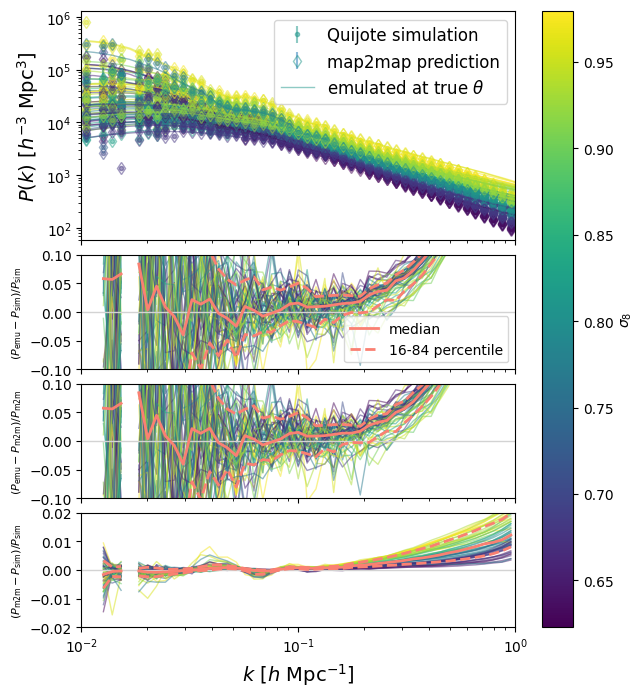

In [ ]:
param_names_compare = ['sigma_8']

for param_name_compare in param_names_compare:
    idx_param = param_names.index(param_name_compare)
    param_vals = np.array([theta[i][idx_param] for i in range(theta.shape[0])])

    normalizer = mpl.colors.Normalize(vmin=np.min(param_vals), vmax=np.max(param_vals))
    sm = mpl.cm.ScalarMappable(norm=normalizer, cmap=mpl.cm.viridis)#.to_rgba(cvals)
    colors = sm.to_rgba(param_vals)
      
    diff_Pksim = Pk_emu - Pk_sim
    diff_Pksim_overPk = diff_Pksim/Pk_sim
    diff_Pksim_overPk_16 = np.percentile(diff_Pksim_overPk, 16, axis=0)
    diff_Pksim_overPk_84 = np.percentile(diff_Pksim_overPk, 84, axis=0)
    diff_Pksim_overPk_med = np.median(diff_Pksim_overPk, axis=0)

    diff_Pkpred = Pk_emu - Pk_pred
    diff_Pkpred_overPk = diff_Pkpred/Pk_pred
    diff_Pkpred_overPk_16 = np.percentile(diff_Pkpred_overPk, 16, axis=0)
    diff_Pkpred_overPk_84 = np.percentile(diff_Pkpred_overPk, 84, axis=0)
    diff_Pkpred_overPk_med = np.median(diff_Pkpred_overPk, axis=0)

    diff = Pk_pred - Pk_sim
    diff_overPk = diff/Pk_sim
    diff_overPk_16 = np.percentile(diff_overPk, 16, axis=0)
    diff_overPk_84 = np.percentile(diff_overPk, 84, axis=0)
    diff_overPk_med = np.median(diff_overPk, axis=0)

    nrows, ncols = 4, 1
    fig, axarr = plt.subplots(nrows, ncols, figsize=(7,8), sharex=True, height_ratios=[2,1,1,1])
    plt.subplots_adjust(hspace=0.1)
        
    # a few examples
    #colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    #print(colors)
    lw = 1
    show_error_all = False
    first = True
    for i, idx_LH in enumerate(idxs_LH_inbounds):
    
        pk_model_unscaled = Pk_emu[i]
        
        label_true, label_emu, label_stdev = None, None, None
        if first:
            label_true = 'Quijote simulation'
            label_emu = r'emulated at true $\theta$'
            label_stdev = r'$0.2*\sigma_\text{stdev}(P_\text{train}(k))$'
            
        if first or show_error_all:
            axarr[0].errorbar(k, Pk_sim[i], yerr=gaussian_error_pk_sim[i], 
                            ls='None', marker='o', markersize=3, alpha=0.5, label=label_true, color=colors[i])
            axarr[0].errorbar(k, Pk_pred[i], yerr=gaussian_error_pk_sim[i], ls='None', marker='d', markersize=6, alpha=0.5, 
                            label='map2map prediction', 
                        markerfacecolor='None', markeredgecolor=colors[i])
        else:
            axarr[0].plot(k, Pk_sim[i], ls='None', marker='o', markersize=3, alpha=0.5, color=colors[i])
            axarr[0].plot(k, Pk_pred[i], ls='None', marker='d', markersize=6, alpha=0.5,
                        markerfacecolor='None', markeredgecolor=colors[i])
        
        axarr[0].plot(k, pk_model_unscaled, ls='-', alpha=0.5, label=label_emu, color=colors[i], lw=lw)

        axarr[1].plot(k, diff_Pksim_overPk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
        axarr[2].plot(k, diff_Pkpred_overPk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
        axarr[3].plot(k, diff_overPk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
            
        first = False
        
    axarr[1].axhline(0, color='lightgrey', lw=1)
    axarr[2].axhline(0, color='lightgrey', lw=1)
    axarr[3].axhline(0, color='lightgrey', lw=1)

    ls_1sig='--'
    axarr[1].axhline(-1, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[1].axhline(1, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[2].axhline(-1, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[2].axhline(1, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[3].axhline(-1, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[3].axhline(1, color='lightgrey', lw=1, ls=ls_1sig)


    alpha_16_84 = 0.5
    axarr[1].plot(k, diff_Pksim_overPk_med, color='salmon', lw=2, label='median')
    axarr[1].plot(k, diff_Pksim_overPk_16, color='salmon', lw=2, ls='--', label='16-84 percentile')
    axarr[1].plot(k, diff_Pksim_overPk_84, color='salmon', lw=2, ls='--')

    axarr[2].plot(k, diff_Pkpred_overPk_med, color='salmon', lw=2)
    axarr[2].plot(k, diff_Pkpred_overPk_16, color='salmon', lw=2, ls='--')
    axarr[2].plot(k, diff_Pkpred_overPk_84, color='salmon', lw=2, ls='--')

    axarr[3].plot(k, diff_overPk_med, color='salmon', lw=2)
    axarr[3].plot(k, diff_overPk_16, color='salmon', lw=2, ls='--')
    axarr[3].plot(k, diff_overPk_84, color='salmon', lw=2, ls='--')

    # plot settings
    plt.xscale('log')
    axarr[0].set_yscale('log')
        
    plt.xlim(1e-2, 1)
    #axarr[0].set_ylim(1e3, 5e5)
    #axarr[0].set_ylim(1e2, 2e5)

    axarr[1].set_ylim(-0.1, 0.1)
    axarr[2].set_ylim(-0.1, 0.1)
    axarr[3].set_ylim(-0.02, 0.02)
        
    handles, labels = axarr[0].get_legend_handles_labels()
    print(labels)

    if len(handles)>1:
        #order = [1,0,2]
        order = [1,2,0]
        #order = [1,0]
        axarr[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=12)
    # axarr[0].legend(fontsize=12)
    handles, labels = axarr[1].get_legend_handles_labels()
    print(labels)
    axarr[1].legend(fontsize=10)

    plt.xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=14)
    axarr[0].set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=14)    
    fontsize_errs = 8
    axarr[1].set_ylabel(r'$(P_\text{emu}-P_\text{sim})/P_\text{sim}$', fontsize=fontsize_errs)
    axarr[2].set_ylabel(r'$(P_\text{emu}-P_\text{m2m})/P_\text{m2m}$', fontsize=fontsize_errs)
    axarr[3].set_ylabel(r'$(P_\text{m2m}-P_\text{sim})/P_\text{sim}$', fontsize=fontsize_errs)

    cbar = plt.colorbar(sm, ax=axarr.ravel().tolist())
    cbar.set_label(utils.param_label_dict[param_name_compare])

/tmp/ipykernel_4117/1635893890.py:12: RuntimeWarning: divide by zero encountered in divide
  diff_Pksim_overPk = diff_Pksim/Pk_sim
/tmp/ipykernel_4117/1635893890.py:18: RuntimeWarning: divide by zero encountered in divide
  diff_Pkpred_overPk = diff_Pkpred/Pk_pred
/tmp/ipykernel_4117/1635893890.py:24: RuntimeWarning: invalid value encountered in divide
  diff_overPk = diff/Pk_sim


['emulated at true $\\theta$', 'Quijote simulation', 'map2map prediction']
['median', '16-84 percentile']


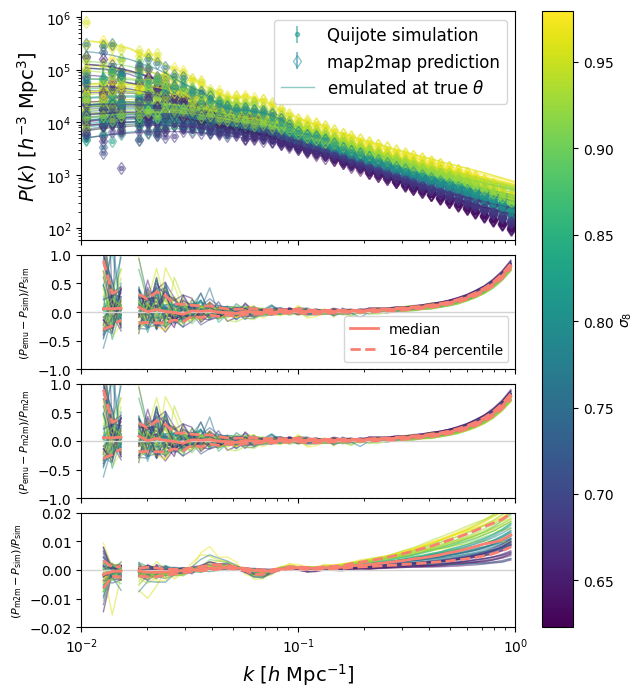

In [ ]:
param_names_compare = ['sigma_8']

for param_name_compare in param_names_compare:
    idx_param = param_names.index(param_name_compare)
    param_vals = np.array([theta[i][idx_param] for i in range(theta.shape[0])])

    normalizer = mpl.colors.Normalize(vmin=np.min(param_vals), vmax=np.max(param_vals))
    sm = mpl.cm.ScalarMappable(norm=normalizer, cmap=mpl.cm.viridis)#.to_rgba(cvals)
    colors = sm.to_rgba(param_vals)
      
    diff_Pksim = Pk_emu - Pk_sim
    diff_Pksim_overPk = diff_Pksim/Pk_sim
    diff_Pksim_overPk_16 = np.percentile(diff_Pksim_overPk, 16, axis=0)
    diff_Pksim_overPk_84 = np.percentile(diff_Pksim_overPk, 84, axis=0)
    diff_Pksim_overPk_med = np.median(diff_Pksim_overPk, axis=0)

    diff_Pkpred = Pk_emu - Pk_pred
    diff_Pkpred_overPk = diff_Pkpred/Pk_pred
    diff_Pkpred_overPk_16 = np.percentile(diff_Pkpred_overPk, 16, axis=0)
    diff_Pkpred_overPk_84 = np.percentile(diff_Pkpred_overPk, 84, axis=0)
    diff_Pkpred_overPk_med = np.median(diff_Pkpred_overPk, axis=0)

    diff = Pk_pred - Pk_sim
    diff_overPk = diff/Pk_sim
    diff_overPk_16 = np.percentile(diff_overPk, 16, axis=0)
    diff_overPk_84 = np.percentile(diff_overPk, 84, axis=0)
    diff_overPk_med = np.median(diff_overPk, axis=0)

    nrows, ncols = 4, 1
    fig, axarr = plt.subplots(nrows, ncols, figsize=(7,8), sharex=True, height_ratios=[2,1,1,1])
    plt.subplots_adjust(hspace=0.1)
        
    # a few examples
    #colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    #print(colors)
    lw = 1
    show_error_all = False
    first = True
    for i, idx_LH in enumerate(idxs_LH_inbounds):
    
        pk_model_unscaled = Pk_emu[i]
        
        label_true, label_emu, label_stdev = None, None, None
        if first:
            label_true = 'Quijote simulation'
            label_emu = r'emulated at true $\theta$'
            label_stdev = r'$0.2*\sigma_\text{stdev}(P_\text{train}(k))$'
            
        if first or show_error_all:
            axarr[0].errorbar(k, Pk_sim[i], yerr=gaussian_error_pk_sim[i], 
                            ls='None', marker='o', markersize=3, alpha=0.5, label=label_true, color=colors[i])
            axarr[0].errorbar(k, Pk_pred[i], yerr=gaussian_error_pk_sim[i], ls='None', marker='d', markersize=6, alpha=0.5, 
                            label='map2map prediction', 
                        markerfacecolor='None', markeredgecolor=colors[i])
        else:
            axarr[0].plot(k, Pk_sim[i], ls='None', marker='o', markersize=3, alpha=0.5, color=colors[i])
            axarr[0].plot(k, Pk_pred[i], ls='None', marker='d', markersize=6, alpha=0.5,
                        markerfacecolor='None', markeredgecolor=colors[i])
        
        axarr[0].plot(k, pk_model_unscaled, ls='-', alpha=0.5, label=label_emu, color=colors[i], lw=lw)

        axarr[1].plot(k, diff_Pksim_overPk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
        axarr[2].plot(k, diff_Pkpred_overPk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
        axarr[3].plot(k, diff_overPk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
            
        first = False
        
    axarr[1].axhline(0, color='lightgrey', lw=1)
    axarr[2].axhline(0, color='lightgrey', lw=1)
    axarr[3].axhline(0, color='lightgrey', lw=1)

    ls_1sig='--'
    axarr[1].axhline(-1, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[1].axhline(1, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[2].axhline(-1, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[2].axhline(1, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[3].axhline(-1, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[3].axhline(1, color='lightgrey', lw=1, ls=ls_1sig)


    alpha_16_84 = 0.5
    axarr[1].plot(k, diff_Pksim_overPk_med, color='salmon', lw=2, label='median')
    axarr[1].plot(k, diff_Pksim_overPk_16, color='salmon', lw=2, ls='--', label='16-84 percentile')
    axarr[1].plot(k, diff_Pksim_overPk_84, color='salmon', lw=2, ls='--')

    axarr[2].plot(k, diff_Pkpred_overPk_med, color='salmon', lw=2)
    axarr[2].plot(k, diff_Pkpred_overPk_16, color='salmon', lw=2, ls='--')
    axarr[2].plot(k, diff_Pkpred_overPk_84, color='salmon', lw=2, ls='--')

    axarr[3].plot(k, diff_overPk_med, color='salmon', lw=2)
    axarr[3].plot(k, diff_overPk_16, color='salmon', lw=2, ls='--')
    axarr[3].plot(k, diff_overPk_84, color='salmon', lw=2, ls='--')

    # plot settings
    plt.xscale('log')
    axarr[0].set_yscale('log')
        
    plt.xlim(1e-2, 1)
    #axarr[0].set_ylim(1e3, 5e5)
    #axarr[0].set_ylim(1e2, 2e5)

    axarr[1].set_ylim(-1, 1)
    axarr[2].set_ylim(-1, 1)
    axarr[3].set_ylim(-0.02, 0.02)
        
    handles, labels = axarr[0].get_legend_handles_labels()
    print(labels)

    if len(handles)>1:
        #order = [1,0,2]
        order = [1,2,0]
        #order = [1,0]
        axarr[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=12)
    # axarr[0].legend(fontsize=12)
    handles, labels = axarr[1].get_legend_handles_labels()
    print(labels)
    axarr[1].legend(fontsize=10)

    plt.xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=14)
    axarr[0].set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=14)    
    fontsize_errs = 8
    axarr[1].set_ylabel(r'$(P_\text{emu}-P_\text{sim})/P_\text{sim}$', fontsize=fontsize_errs)
    axarr[2].set_ylabel(r'$(P_\text{emu}-P_\text{m2m})/P_\text{m2m}$', fontsize=fontsize_errs)
    axarr[3].set_ylabel(r'$(P_\text{m2m}-P_\text{sim})/P_\text{sim}$', fontsize=fontsize_errs)

    cbar = plt.colorbar(sm, ax=axarr.ravel().tolist())
    cbar.set_label(utils.param_label_dict[param_name_compare])

/tmp/ipykernel_211621/1241004147.py:50: RuntimeWarning: invalid value encountered in divide
  axarr[1].plot(k, (Pk_pred[i]-Pk_sim[i])/gaussian_error_pk_pred[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
/tmp/ipykernel_211621/1241004147.py:51: RuntimeWarning: invalid value encountered in divide
  axarr[2].plot(k, (Pk_pred[i]-Pk_sim[i])/Pk_sim[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
/tmp/ipykernel_211621/1241004147.py:52: RuntimeWarning: invalid value encountered in divide
  axarr[3].plot(k, (Tk_pred[i]-Tk_sim[i])/Tk_sim[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
/tmp/ipykernel_211621/1241004147.py:70: RuntimeWarning: invalid value encountered in divide
  diff_overG = diff/gaussian_error_pk_sim
/tmp/ipykernel_211621/1241004147.py:75: RuntimeWarning: invalid value encountered in divide
  diff_overPk = diff/Pk_sim
/tmp/ipykernel_211621/1241004147.py:81: RuntimeWarning: invalid value encountered in divide
  diffTk_overTk = diffTk/Tk_sim


['Quijote simulation', 'map2map prediction']
['median', '16-84 percentile']


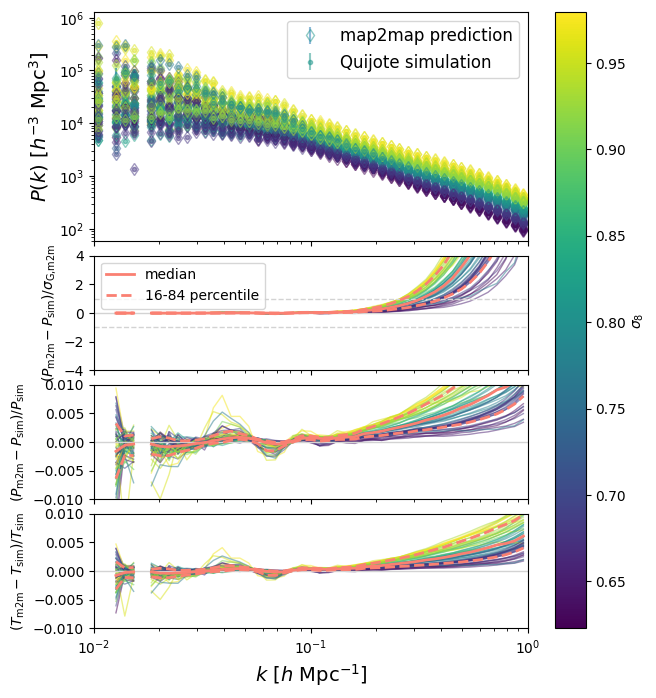

In [ ]:
param_names_compare = ['sigma_8']

Tk_sim = np.sqrt(Pk_sim)
Tk_pred = np.sqrt(Pk_pred)

for param_name_compare in param_names_compare:
    idx_param = param_names.index(param_name_compare)
    param_vals = np.array([theta[i][idx_param] for i in range(theta.shape[0])])

    normalizer = mpl.colors.Normalize(vmin=np.min(param_vals), vmax=np.max(param_vals))
    sm = mpl.cm.ScalarMappable(norm=normalizer, cmap=mpl.cm.viridis)#.to_rgba(cvals)
    colors = sm.to_rgba(param_vals)
        

    nrows, ncols = 4, 1
    fig, axarr = plt.subplots(nrows, ncols, figsize=(7,8), sharex=True, height_ratios=[2,1,1,1])
    plt.subplots_adjust(hspace=0.1)
        
    # a few examples
    #colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    #print(colors)
    lw = 1
    show_error_all = False
    first = True
    for i, idx_LH in enumerate(idxs_LH_inbounds):
    
        pk_model_unscaled = Pk_emu[i]
        
        label_true, label_emu, label_stdev = None, None, None
        if first:
            label_true = 'Quijote simulation'
            label_emu = r'emulated at true $\theta$'
            label_stdev = r'$0.2*\sigma_\text{stdev}(P_\text{train}(k))$'
            
        if first or show_error_all:
            axarr[0].errorbar(k, Pk_sim[i], yerr=gaussian_error_pk_sim[i], 
                            ls='None', marker='o', markersize=3, alpha=0.5, label=label_true, color=colors[i])
            axarr[0].errorbar(k, Pk_pred[i], yerr=gaussian_error_pk_sim[i], ls='None', marker='d', markersize=6, alpha=0.5, 
                            label='map2map prediction', 
                        markerfacecolor='None', markeredgecolor=colors[i])
        else:
            axarr[0].plot(k, Pk_sim[i], ls='None', marker='o', markersize=3, alpha=0.5, color=colors[i])
            axarr[0].plot(k, Pk_pred[i], ls='None', marker='d', markersize=6, alpha=0.5,
                        markerfacecolor='None', markeredgecolor=colors[i])
        
        #axarr[0].plot(k, pk_model_unscaled, ls='-', alpha=0.5, label=label_emu, color=colors[i], lw=lw)

        #axarr[1].plot(k, (pk_model_unscaled-Pk_sim[i])/gaussian_error_pk_sim[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
        #axarr[2].plot(k, (pk_model_unscaled-Pk_pred[i])/gaussian_error_pk_sim[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
        axarr[1].plot(k, (Pk_pred[i]-Pk_sim[i])/gaussian_error_pk_pred[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
        axarr[2].plot(k, (Pk_pred[i]-Pk_sim[i])/Pk_sim[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
        axarr[3].plot(k, (Tk_pred[i]-Tk_sim[i])/Tk_sim[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
            
        first = False
        
    axarr[1].axhline(0, color='lightgrey', lw=1)
    axarr[2].axhline(0, color='lightgrey', lw=1)
    axarr[3].axhline(0, color='lightgrey', lw=1)
    # axarr[4].axhline(1.0, color='lightgrey', lw=1)

    ls_1sig='--'
    axarr[1].axhline(-1, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[1].axhline(1, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[2].axhline(-1, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[2].axhline(1, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[3].axhline(-1, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[3].axhline(1, color='lightgrey', lw=1, ls=ls_1sig)

    diff = Pk_pred - Pk_sim
    diff_overG = diff/gaussian_error_pk_sim
    diff_overG_16 = np.percentile(diff_overG, 16, axis=0)
    diff_overG_84 = np.percentile(diff_overG, 84, axis=0)
    diff_overG_med = np.median(diff_overG, axis=0)

    diff_overPk = diff/Pk_sim
    diff_overPk_16 = np.percentile(diff_overPk, 16, axis=0)
    diff_overPk_84 = np.percentile(diff_overPk, 84, axis=0)
    diff_overPk_med = np.median(diff_overPk, axis=0)

    diffTk = Tk_pred - Tk_sim
    diffTk_overTk = diffTk/Tk_sim
    diffTk_overTk_16 = np.percentile(diffTk_overTk, 16, axis=0)
    diffTk_overTk_84 = np.percentile(diffTk_overTk, 84, axis=0)
    diffTk_overTk_med = np.median(diffTk_overTk, axis=0)
    
    axarr[1].plot(k, diff_overG_med, color='salmon', lw=2, label='median')
    axarr[1].plot(k, diff_overG_16, color='salmon', lw=2, ls='--', label='16-84 percentile')
    axarr[1].plot(k, diff_overG_84, color='salmon', lw=2, ls='--')

    axarr[2].plot(k, diff_overPk_med, color='salmon', lw=2)
    axarr[2].plot(k, diff_overPk_16, color='salmon', lw=2, ls='--')
    axarr[2].plot(k, diff_overPk_84, color='salmon', lw=2, ls='--')

    axarr[3].plot(k, diffTk_overTk_med, color='salmon', lw=2)
    axarr[3].plot(k, diffTk_overTk_16, color='salmon', lw=2, ls='--')
    axarr[3].plot(k, diffTk_overTk_84, color='salmon', lw=2, ls='--')


    # plot settings
    plt.xscale('log')
    axarr[0].set_yscale('log')
        
    plt.xlim(1e-2, 1)
    #axarr[0].set_ylim(1e3, 5e5)
    #axarr[0].set_ylim(1e2, 2e5)

    axarr[1].set_ylim(-4, 4)
    axarr[2].set_ylim(-0.01, 0.01)
    axarr[3].set_ylim(-0.01, 0.01)
        
    handles, labels = axarr[0].get_legend_handles_labels()
    print(labels)

    if len(handles)>1:
        #order = [1,0,2]
        #order = [1,2,0]
        order = [1,0]
        axarr[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=12)
    # axarr[0].legend(fontsize=12)
    handles, labels = axarr[1].get_legend_handles_labels()
    print(labels)
    axarr[1].legend(fontsize=10)

    plt.xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=14)
    axarr[0].set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=14)    
    fontsize_errs = 10
    axarr[1].set_ylabel(r'$(P_\text{m2m}-P_\text{sim})/\sigma_\text{G,m2m}$', fontsize=fontsize_errs)
    axarr[2].set_ylabel(r'$(P_\text{m2m}-P_\text{sim})/P_\text{sim}$', fontsize=fontsize_errs)
    axarr[3].set_ylabel(r'$(T_\text{m2m}-T_\text{sim})/T_\text{sim}$', fontsize=fontsize_errs)

    cbar = plt.colorbar(sm, ax=axarr.ravel().tolist())
    cbar.set_label(utils.param_label_dict[param_name_compare])

### Compare resolutions

In [56]:
param_names_all = ['omega_cold', 'sigma_8', 'h', 'omega_baryon', 'n_s', 'seed']
param_names = ['omega_cold', 'sigma_8', 'h']
param_names_fixed = [name for name in param_names_all if name not in param_names]
idxs_param_names = [param_names_all.index(name) for name in param_names]

tag_pk = '_b0000'
idx_LH = 0

tag_mocks = '_HR'
dir_mocks = f'../data/cosmolib{tag_mocks}'
dir_pks = f'../data/pks_cosmolib/pks{tag_mocks}{tag_pk}'
bias_params = np.loadtxt(f'{dir_pks}/bias_params.txt')

tag_fields_extra = ''
fn_pk_hr = f'{dir_pks}/pk_{idx_LH}{tag_fields_extra}.npy'

tag_fields_extra = '_2GpcBox'
fn_pk_hr_2gpc = f'{dir_pks}/pk_{idx_LH}{tag_fields_extra}.npy'

/tmp/ipykernel_4117/4026904195.py:23: RuntimeWarning: invalid value encountered in divide
  ax1.plot(kk, (pks[0]-pks[1])/pks[1], ls='-', alpha=alpha, color=colors[0])
/tmp/ipykernel_4117/4026904195.py:26: RuntimeWarning: invalid value encountered in divide
  ax2.plot(kk, (pks[0]-pks[1])/errGs[0], ls='-', alpha=alpha, color=colors[0])


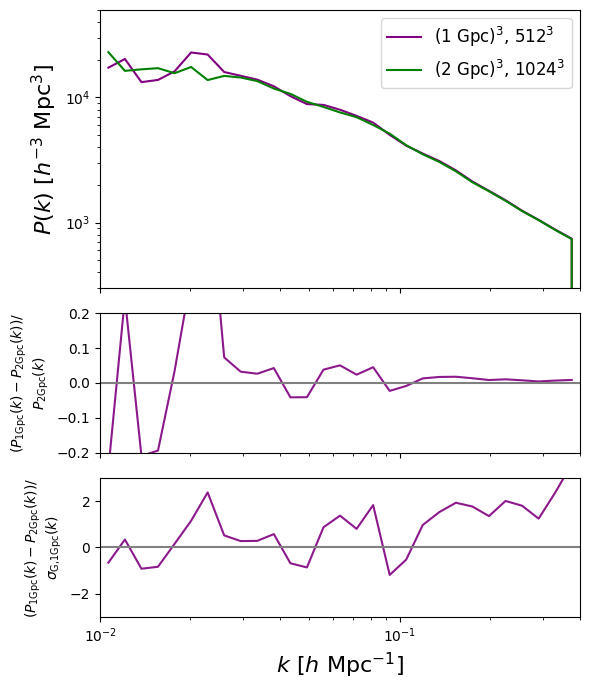

In [57]:
fns_pk = [fn_pk_hr, fn_pk_hr_2gpc]
colors = ['purple', 'green']
labels = [r'(1 Gpc)$^3$, $512^3$', 
          r'(2 Gpc)$^3$, $1024^3$']

nrows, ncols = 3, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,7), sharex=True, height_ratios=[2,1,1])
plt.subplots_adjust(hspace=0.01)
ax, ax1, ax2 = axarr

pks = []
errGs = []
for i in range(len(fns_pk)):
    pk_obj = np.load(fns_pk[i], allow_pickle=True).item()
    pk = pk_obj['pk']
    pks.append(pk)
    kk = pk_obj['k']
    errG = pk_obj['pk_gaussian_error']
    errGs.append(errG)
    ax.loglog(kk, pk, label=labels[i], color=colors[i])
r'(1 Gpc)$^3$, $512^3$',
alpha = 0.9
ax1.plot(kk, (pks[0]-pks[1])/pks[1], ls='-', alpha=alpha, color=colors[0])
ax1.axhline(0.0, color='grey')

ax2.plot(kk, (pks[0]-pks[1])/errGs[0], ls='-', alpha=alpha, color=colors[0])
ax2.axhline(0.0, color='grey')

plt.xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)

ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)
ax1.set_ylabel(r'$(P_\text{1Gpc}(k)-P_\text{2Gpc}(k))/$'+'\n'+r'$P_\text{2Gpc}(k)$')
ax2.set_ylabel(r'$(P_\text{1Gpc}(k)-P_\text{2Gpc}(k))/$'+'\n'+r'$\sigma_\text{G,1Gpc}(k)$')

plt.xlim(1e-2, 0.4)

ax.set_ylim(3e2, 5e4)
ax1.set_ylim(-0.2, 0.2)
ax2.set_ylim(-3, 3)

ax.legend(fontsize=12)

mpl.pyplot.tight_layout()
mpl.pyplot.show()

In [58]:
param_names_all = ['omega_cold', 'sigma_8', 'h', 'omega_baryon', 'n_s', 'seed']
param_names = ['omega_cold', 'sigma_8', 'h']
param_names_fixed = [name for name in param_names_all if name not in param_names]
idxs_param_names = [param_names_all.index(name) for name in param_names]

tag_pk = '_b0000'
idx_LH = 0

tag_mocks = ''
dir_mocks = f'../data/cosmolib{tag_mocks}'
dir_pks = f'../data/pks_cosmolib/pks{tag_mocks}{tag_pk}'
bias_params = np.loadtxt(f'{dir_pks}/bias_params.txt')

tag_fields_extra = ''
fn_pk_lr = f'{dir_pks}/pk_{idx_LH}{tag_fields_extra}.npy'

tag_mocks = '_FixedPk'
dir_mocks = f'../data/cosmolib{tag_mocks}'
dir_pks = f'../data/pks_cosmolib/pks{tag_mocks}{tag_pk}'
bias_params = np.loadtxt(f'{dir_pks}/bias_params.txt')

tag_fields_extra = ''
fn_pk_fixed = f'{dir_pks}/pk_{idx_LH}{tag_fields_extra}.npy'

In [59]:
pk_obj = np.load(fn_pk_lr, allow_pickle=True).item()
k = pk_obj['k']

In [60]:
# check if this is correct cosmo !! 
tag_mocks = ''
dir_mocks = f'../data/cosmolib{tag_mocks}'
idx_LH_str = str(idx_LH)
fn_params = f'{dir_mocks}/LH{idx_LH_str}/cosmo_{idx_LH_str}.txt'
param_vals = np.loadtxt(fn_params)
param_names_all = ['omega_cold', 'sigma_8', 'h', 'omega_baryon', 'n_s', 'seed']

param_dict = dict(zip(param_names_all, param_vals))

#param_names = ['omega_cold', 'sigma_8', 'h']

for param_name in param_names_all:
    if param_name=='omega_m':
        # no neutrinos, so omega_cold = omega_m
        emu_param_name = 'omega_cold'
    elif param_name=='seed':
        continue
    else:
        emu_param_name = param_names_2_emu_param_names[param_name]
    cosmo_params[emu_param_name] = param_dict[param_name]

print(cosmo_params)
_, pk_emu, = emu_mpk_ext.get_nonlinear_pk(k=k, cold=True, **cosmo_params)

{'neutrino_mass': 0.0, 'w0': -1.0, 'wa': 0.0, 'expfactor': 1, 'omega_cold': 0.2775274936564327, 'sigma8_cold': 0.7049140324569382, 'hubble': 0.7241123952301097, 'omega_baryon': 0.049, 'ns': 0.9624}


In [61]:
# check if this is correct cosmo !! 
# did this bc the params for LH0 and LH0_HR are diff, but structures look the same, so think one is right,
# picked by looking at one that obvs fit better
tag_mocks = '_HR'
dir_mocks = f'../data/cosmolib{tag_mocks}'
idx_LH_str = str(idx_LH)
fn_params = f'{dir_mocks}/LH{idx_LH_str}/cosmo_{idx_LH_str}.txt'
param_vals = np.loadtxt(fn_params)
param_names_all = ['omega_cold', 'sigma_8', 'h', 'omega_baryon', 'n_s', 'seed']

param_dict = dict(zip(param_names_all, param_vals))

#param_names = ['omega_cold', 'sigma_8', 'h']

for param_name in param_names_all:
    if param_name=='omega_m':
        # no neutrinos, so omega_cold = omega_m
        emu_param_name = 'omega_cold'
    elif param_name=='seed':
        continue
    else:
        emu_param_name = param_names_2_emu_param_names[param_name]
    cosmo_params[emu_param_name] = param_dict[param_name]

print(cosmo_params) 
_, pk_emu_othercosmo, = emu_mpk_ext.get_nonlinear_pk(k=k, cold=True, **cosmo_params)

{'neutrino_mass': 0.0, 'w0': -1.0, 'wa': 0.0, 'expfactor': 1, 'omega_cold': 0.3812428867600053, 'sigma8_cold': 0.7439089784131745, 'hubble': 0.6048744220344231, 'omega_baryon': 0.049, 'ns': 0.9624}


/tmp/ipykernel_4117/1260257959.py:23: RuntimeWarning: divide by zero encountered in divide
  ax1.plot(kk, (pk_emu-pk)/pk, ls='-', alpha=alpha, color=colors[i])
/tmp/ipykernel_4117/1260257959.py:24: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(kk, (pk_emu-pk)/errG, ls='-', alpha=alpha, color=colors[i])


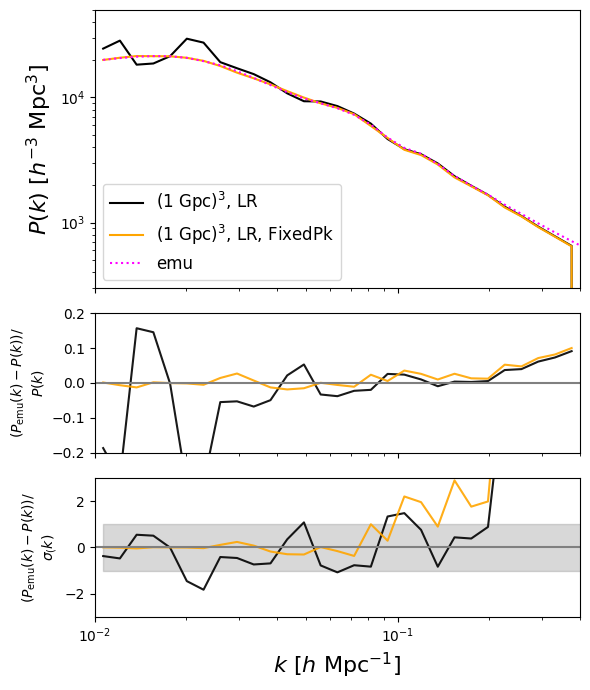

In [62]:
fns_pk = [fn_pk_lr, fn_pk_fixed]
colors = ['black', 'orange']
labels = [r'(1 Gpc)$^3$, LR', 
          r'(1 Gpc)$^3$, LR, FixedPk']

nrows, ncols = 3, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,7), sharex=True, height_ratios=[2,1,1])
plt.subplots_adjust(hspace=0.01)
ax, ax1, ax2 = axarr

pks = []
errGs = []
for i in range(len(fns_pk)):
#for i in [2]:
    pk_obj = np.load(fns_pk[i], allow_pickle=True).item()
    pk = pk_obj['pk']
    pks.append(pk)
    kk = pk_obj['k']
    errG = pk_obj['pk_gaussian_error']
    errGs.append(errG)
    ax.plot(kk, pk, label=labels[i], color=colors[i])
    
    ax1.plot(kk, (pk_emu-pk)/pk, ls='-', alpha=alpha, color=colors[i])
    ax2.plot(kk, (pk_emu-pk)/errG, ls='-', alpha=alpha, color=colors[i])

ax.plot(kk, pk_emu, label='emu', color='magenta', ls=':')
#ax.plot(kk, pk_emu_
#        cosmo, label='emu, other set of cosmo params', color='blue', ls=':')

alpha = 0.9
ax1.axhline(0.0, color='grey')

#ax2.plot(kk, (pks[0]-pks[1])/errGs[0], ls='-', alpha=alpha, color=colors[0])
ax2.axhline(0.0, color='grey')
ax2.fill_between(kk, -1, 1, color='grey', alpha=0.3)

plt.xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)

ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)
ax1.set_ylabel(r'$(P_\text{emu}(k)-P(k))/$'+'\n'+r'$P(k)$')
ax2.set_ylabel(r'$(P_\text{emu}(k)-P(k))/$'+'\n'+r'$\sigma_(k)$')

plt.xlim(1e-2, 0.4)
plt.xscale('log')
ax.set_yscale('log')

ax.set_ylim(3e2, 5e4)
ax1.set_ylim(-0.2, 0.2)
ax2.set_ylim(-3, 3)

ax.legend(fontsize=12)


mpl.pyplot.tight_layout()
mpl.pyplot.show()

/tmp/ipykernel_4117/2039246157.py:25: RuntimeWarning: divide by zero encountered in divide
  ax1.plot(kk, (pk_emu-pk)/pk, ls='-', alpha=alpha, color=colors[i])
/tmp/ipykernel_4117/2039246157.py:26: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(kk, (pk_emu-pk)/errG, ls='-', alpha=alpha, color=colors[i])


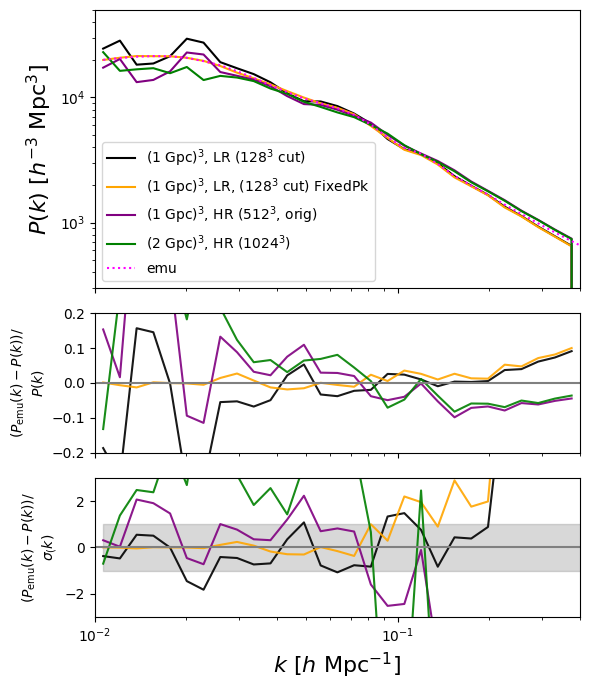

In [64]:
fns_pk = [fn_pk_lr, fn_pk_fixed, fn_pk_hr, fn_pk_hr_2gpc]
colors = ['black', 'orange', 'purple', 'green']
labels = [r'(1 Gpc)$^3$, LR ($128^3$ cut)', 
          r'(1 Gpc)$^3$, LR, ($128^3$ cut) FixedPk',
          r'(1 Gpc)$^3$, HR ($512^3$, orig)', 
          r'(2 Gpc)$^3$, HR ($1024^3$)']

nrows, ncols = 3, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,7), sharex=True, height_ratios=[2,1,1])
plt.subplots_adjust(hspace=0.01)
ax, ax1, ax2 = axarr

pks = []
errGs = []
for i in range(len(fns_pk)):

    pk_obj = np.load(fns_pk[i], allow_pickle=True).item()
    pk = pk_obj['pk']
    pks.append(pk)
    kk = pk_obj['k']
    errG = pk_obj['pk_gaussian_error']
    errGs.append(errG)
    ax.plot(kk, pk, label=labels[i], color=colors[i])

    ax1.plot(kk, (pk_emu-pk)/pk, ls='-', alpha=alpha, color=colors[i])
    ax2.plot(kk, (pk_emu-pk)/errG, ls='-', alpha=alpha, color=colors[i])

ax.plot(kk, pk_emu, label='emu', color='magenta', ls=':')

alpha = 0.9
ax1.axhline(0.0, color='grey')

ax2.axhline(0.0, color='grey')
ax2.fill_between(kk, -1, 1, color='grey', alpha=0.3)

plt.xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)

ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)
ax1.set_ylabel(r'$(P_\text{emu}(k)-P(k))/$'+'\n'+r'$P(k)$')
ax2.set_ylabel(r'$(P_\text{emu}(k)-P(k))/$'+'\n'+r'$\sigma_(k)$')

plt.xlim(1e-2, 0.4)
plt.xscale('log')
ax.set_yscale('log')

ax.set_ylim(3e2, 5e4)
ax1.set_ylim(-0.2, 0.2)
ax2.set_ylim(-3, 3)

ax.legend(fontsize=10)

mpl.pyplot.tight_layout()
mpl.pyplot.show()